In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
from torchvision.models import ResNet18_Weights, VGG16_Weights

In [29]:
# Set random seed for reproducibility
torch.manual_seed(42)

CNN fusion with ResNet and Linear 

In [30]:
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        self.cnn = models.resnet18(weights=ResNet18_Weights.DEFAULT)  # Use weights parameter
        self.cnn.fc = nn.Linear(self.cnn.fc.in_features, 64)
        
    def forward(self, x):
        return self.cnn(x)

In [31]:
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 10)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
        return out

In [32]:
# Data preparation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [33]:
# Load the dataset
full_dataset = datasets.ImageFolder('I:/Project/DATASET', transform=transform)

In [34]:
# Split the dataset into training, validation, and testing sets
train_size = int(0.7 * len(full_dataset))  # 70% for training
val_size = int(0.15 * len(full_dataset))   # 15% for validation
test_size = len(full_dataset) - train_size - val_size  # 15% for testing


In [35]:

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

In [36]:
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 1456
Validation set size: 312
Test set size: 312


In [37]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [38]:
# Define the fusion model
class FusionModel(nn.Module):
    def __init__(self):
        super(FusionModel, self).__init__()
        self.model1 = Model1()
        self.model2 = Model2()
        
    def forward(self, x):
        out1 = self.model1(x)
        out2 = self.model2(out1)
        return out2

In [39]:
# Training loop
fusion_model = FusionModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fusion_model.parameters(), lr=0.001)

In [40]:
for epoch in range(10):
    fusion_model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = fusion_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/10], Loss: {loss.item():.4f}')



Epoch [1/10], Loss: 0.1599
Epoch [2/10], Loss: 0.7273
Epoch [3/10], Loss: 0.1708
Epoch [4/10], Loss: 0.5138
Epoch [5/10], Loss: 0.0952
Epoch [6/10], Loss: 0.0928
Epoch [7/10], Loss: 0.0196
Epoch [8/10], Loss: 0.0117
Epoch [9/10], Loss: 0.2012
Epoch [10/10], Loss: 0.0037


In [41]:
# Validation loop
fusion_model.eval()
val_loss = 0
val_correct = 0
val_labels = []
val_preds = []

In [42]:
with torch.no_grad():
    for images, labels in val_loader:
        outputs = fusion_model(images)
        val_loss += criterion(outputs, labels).item()
        _, predicted = torch.max(outputs.data, 1)
        val_correct += (predicted == labels).sum().item()
        val_labels.extend(labels.numpy())
        val_preds.extend(predicted.numpy())

In [43]:
val_loss /= len(val_loader)
val_accuracy = val_correct / len(val_dataset)
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Validation Loss: 0.5715, Validation Accuracy: 0.8558


In [44]:
# Test loop
test_loss = 0
test_correct = 0
test_labels = []
test_preds = []


In [45]:
with torch.no_grad():
    for images, labels in test_loader:
        outputs = fusion_model(images)
        test_loss += criterion(outputs, labels).item()
        _, predicted = torch.max(outputs.data, 1)
        test_correct += (predicted == labels).sum().item()
        test_labels.extend(labels.numpy())
        test_preds.extend(predicted.numpy())


In [46]:
test_loss /= len(test_loader)
test_accuracy = test_correct / len(test_dataset)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.6061, Test Accuracy: 0.8590


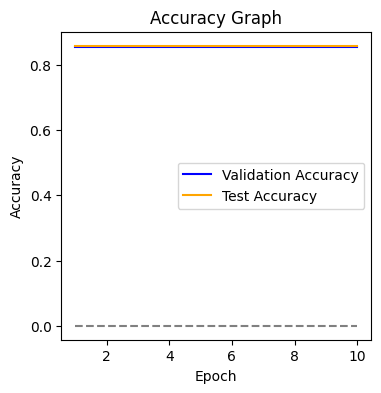

In [54]:
# Plotting validation and test accuracy
plt.figure(figsize=(4, 4))
plt.plot(range(1, 11), [0] * 10, color='gray', linestyle='--')
plt.plot([1, 10], [val_accuracy, val_accuracy], color='blue', label='Validation Accuracy')
plt.plot([1, 10], [test_accuracy, test_accuracy], color='orange', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show()

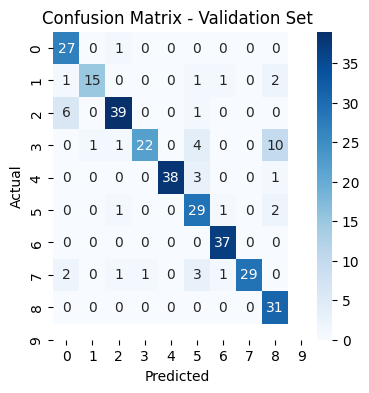

In [53]:
# Confusion Matrix for Validation
conf_matrix_val = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

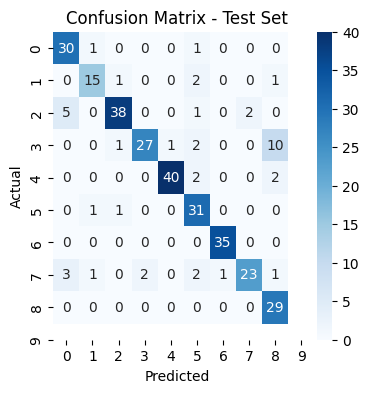

In [52]:
# Confusion Matrix for Test
conf_matrix_test = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

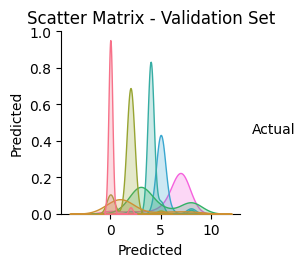

In [50]:
# Scatter Matrix
val_df = pd.DataFrame({'Actual': val_labels, 'Predicted': val_preds})
sns.pairplot(val_df, hue='Actual', palette='husl')
plt.title('Scatter Matrix - Validation Set')
plt.show()

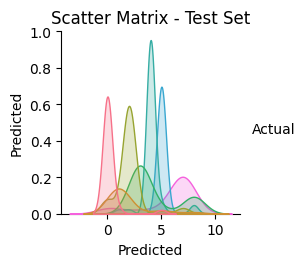

In [51]:
test_df = pd.DataFrame({'Actual': test_labels, 'Predicted': test_preds})
sns.pairplot(test_df, hue='Actual', palette='husl')
plt.title('Scatter Matrix - Test Set')
plt.show()